# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [3]:
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from dataset_utils.cityscapes import Cityscapes
from dataset_utils.cityscapes import CityscapesDataModule
from dataset_utils.woodscape import WoodScapeDataset
from dataset_utils.woodscape import WoodScapeDataModule
from dataset_utils import WoodScapeSoilingDataset
from dataset_utils import WoodScapeSoilingDataModule

In [6]:
from utils.display_images import denormalize_img
from utils import show_dataset_image, show_dataset_mask
from utils import show_prediction_images, show_prediction_uncertainty_images

In [7]:
from deeplab_v3p import DeepLabV3PlusModule
from dropblock import DropBlock2D

In [8]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

# Load Entropy

In [10]:
ws_dlv3p_h_z_ws_normal_valid_samples_np = np.load('./EXPERIMENTS/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/ws_dlv3p_h_z_ws_normal_valid_samples_np.npy')

ws_dlv3p_h_z_ws_normal_test_samples_np = np.load('./EXPERIMENTS/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/ws_dlv3p_h_z_ws_normal_test_samples_np.npy')

ws_dlv3p_h_z_ws_anomal_valid_samples_np = np.load('./EXPERIMENTS/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/ws_dlv3p_h_z_ws_anomal_valid_samples_np.npy')

ws_dlv3p_h_z_ws_anomal_test_samples_np = np.load('./EXPERIMENTS/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/ws_dlv3p_h_z_ws_anomal_test_samples_np.npy')

ws_dlv3p_h_z_cs_483640_valid_samples_np = np.load('./EXPERIMENTS/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/ws_dlv3p_h_z_cs_483640_valid_samples_np.npy')

ws_dlv3p_h_z_cs_483640_test_samples_np = np.load('./EXPERIMENTS/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/ws_dlv3p_h_z_cs_483640_test_samples_np.npy')

ws_dlv3p_h_z_ws_soil_483640_valid_samples_np = np.load('./EXPERIMENTS/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.npy')

ws_dlv3p_h_z_ws_soil_483640_test_samples_np = np.load('./EXPERIMENTS/semantic_segmentation/deeplabv3p/embeddings/woodscape/entropy/ws_dlv3p_h_z_ws_soil_483640_test_samples_np.npy')

In [94]:
ic(ws_dlv3p_h_z_ws_normal_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_normal_test_samples_np.shape);
ic(ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape);
ic(ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape);

ic| ws_dlv3p_h_z_ws_normal_valid_samples_np.shape: (1482, 2048)
ic| ws_dlv3p_h_z_ws_normal_test_samples_np.shape: (823, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_valid_samples_np.shape: (800, 2048)
ic| ws_dlv3p_h_z_ws_soil_483640_test_samples_np.shape: (1000, 2048)


# Entropy 2D Projection

(2964, 2048)
(2964, 1)
(2964, 2)


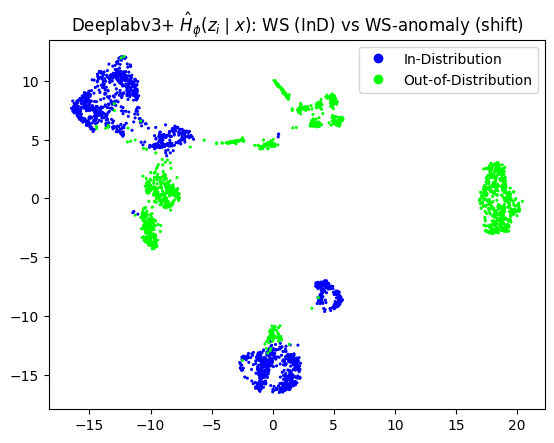

In [11]:
plot_samples_pacmap(ws_dlv3p_h_z_ws_normal_valid_samples_np,
                    ws_dlv3p_h_z_ws_anomal_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}_{\phi}(z_i \mid x)$: WS (InD) vs WS-anomaly (shift)")

(1982, 2048)
(1982, 1)
(1982, 2)


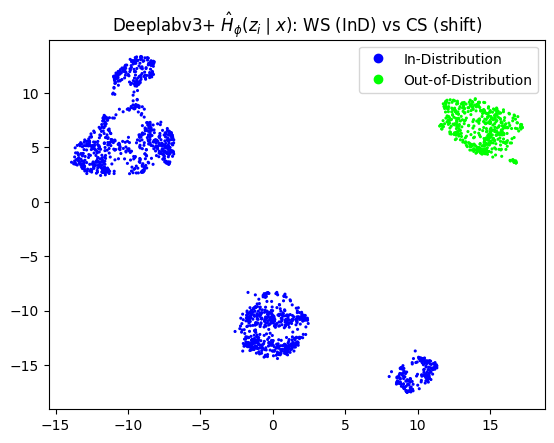

In [12]:
plot_samples_pacmap(ws_dlv3p_h_z_ws_normal_valid_samples_np,
                    ws_dlv3p_h_z_cs_483640_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}_{\phi}(z_i \mid x)$: WS (InD) vs CS (shift)")

(2282, 2048)
(2282, 1)
(2282, 2)


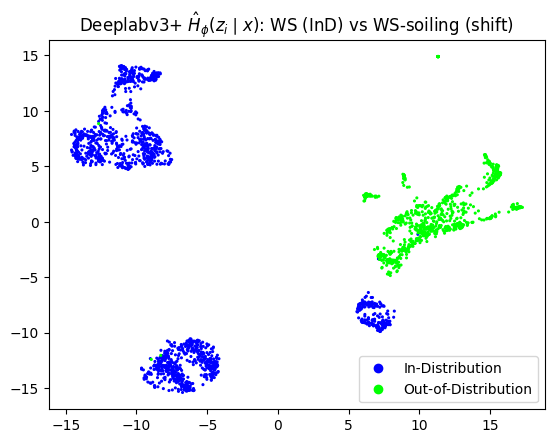

In [13]:
plot_samples_pacmap(ws_dlv3p_h_z_ws_normal_valid_samples_np,
                    ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}_{\phi}(z_i \mid x)$: WS (InD) vs WS-soiling (shift)")

# Build Deeplabv3+ Woodscape Dataset Shift Detector

## Train Dataset 1: ws-normal-valid vs ws-anomalies-valid

In [14]:
(h_train_ws_normal_valid_ws_anomal_valid,
 labels_h_train_ws_normal_valid_ws_anomal_valid,
 h_test_ws_normal_test_ws_anomal_test,
 labels_h_test_ws_normal_test_ws_anomal_test, _) = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                          ws_dlv3p_h_z_ws_anomal_valid_samples_np,  # reference for training set
                                                                          ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                          ws_dlv3p_h_z_ws_anomal_test_samples_np)

Train Dataset Samples shape:  (2964, 16)
Train Dataset Labels shape:  (2964,)
Test Dataset Samples shape:  (1646, 16)
Test Dataset Labels shape:  (1646,)


### Test Dataset 1: ws-normal-test & ws-anomalies-test

In [15]:
ic(h_test_ws_normal_test_ws_anomal_test.shape);
ic(labels_h_test_ws_normal_test_ws_anomal_test.shape);

ic| h_test_ws_normal_test_ws_anomal_test.shape: (1646, 16)
ic| labels_h_test_ws_normal_test_ws_anomal_test.shape: (1646,)


### Test Dataset 2: ws-normal-test & cs-normal-test

In [16]:
_, _, h_test_ws_normal_test_cs_normal_test, labels_h_test_ws_normal_test_cs_normal_test, _ = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_anomal_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                                                                    ws_dlv3p_h_z_cs_483640_test_samples_np)

Train Dataset Samples shape:  (2964, 16)
Train Dataset Labels shape:  (2964,)
Test Dataset Samples shape:  (2348, 16)
Test Dataset Labels shape:  (2348,)


### Test Datset 3: ws-normal-test & ws-soiling-test

In [17]:
_, _, h_test_ws_normal_test_ws_soil_test, labels_h_test_ws_normal_test_ws_soil_test, _ = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                                                                ws_dlv3p_h_z_ws_anomal_valid_samples_np,  # reference for training set
                                                                                                                ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                                                                ws_dlv3p_h_z_ws_soil_483640_test_samples_np)

Train Dataset Samples shape:  (2964, 16)
Train Dataset Labels shape:  (2964,)
Test Dataset Samples shape:  (1823, 16)
Test Dataset Labels shape:  (1823,)


## Train Model Dataset 1: ws-normal-valid & ws-anomal-valid

In [18]:
dlv3p_ws_h_z_odd_detector_1 = KDEClassifier(bandwidth=0.8)
dlv3p_ws_h_z_odd_detector_1.fit(h_train_ws_normal_valid_ws_anomal_valid, labels_h_train_ws_normal_valid_ws_anomal_valid)

KDEClassifier(bandwidth=0.8)

## Results Test Dataset 1

In [55]:
dlv3p_ws_h_z_odd_detector_1_results_test_ds_1 = get_ood_detector_results("dlv3p-ws detector 1: test ds 1",
                                                                         dlv3p_ws_h_z_odd_detector_1,
                                                                         h_test_ws_normal_test_ws_anomal_test,
                                                                         labels_h_test_ws_normal_test_ws_anomal_test)

dlv3p_ws_h_z_odd_detector_1_results_test_ds_1
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_1['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_1['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_1['f1'][0].item()))

dlv3p-ws detector 1: test ds 1
AUROC: 0.9998
FPR95: 0.0000
F1: 0.9921


dlv3p-ws detector 1: test ds 1


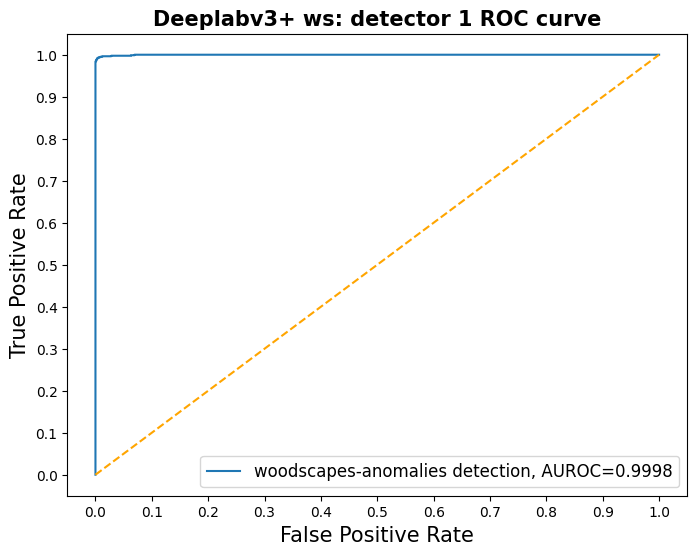

In [52]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_1_results_test_ds_1,
                      "woodscapes-anomalies detection",
                      "Deeplabv3+ ws: detector 1 ROC curve")

## Results Test Dataset 2
ws-normal-test vs. cs-normal-test

In [57]:
dlv3p_ws_h_z_odd_detector_1_results_test_ds_2 = get_ood_detector_results("dlv3p-ws detector 1: test ds 2",
                                                                         dlv3p_ws_h_z_odd_detector_1,
                                                                         h_test_ws_normal_test_cs_normal_test,
                                                                         labels_h_test_ws_normal_test_cs_normal_test)

dlv3p_ws_h_z_odd_detector_1_results_test_ds_2
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_2['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_2['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_2['f1'][0].item()))

dlv3p-ws detector 1: test ds 2
AUROC: 0.9908
FPR95: 0.0269
F1: 0.8254


dlv3p-ws detector 1: test ds 2


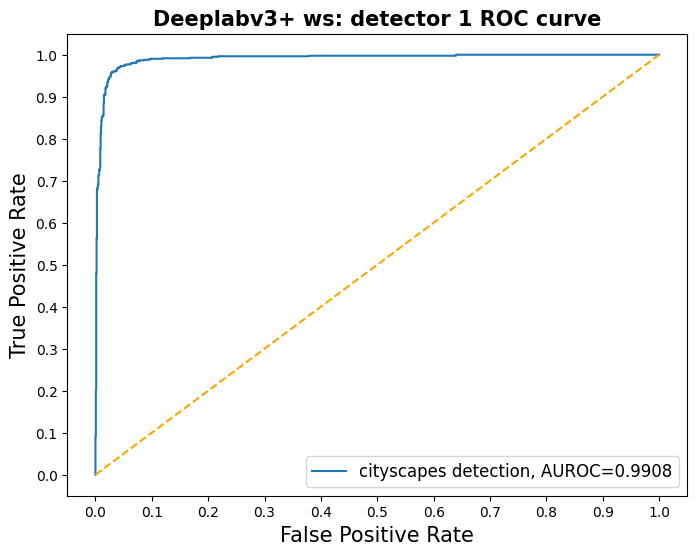

In [58]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_1_results_test_ds_2,
                      "cityscapes detection",
                      "Deeplabv3+ ws: detector 1 ROC curve")

## Results Test Dataset 3
ws-normal-test vs. ws-soiling-test

In [59]:
dlv3p_ws_h_z_odd_detector_1_results_test_ds_3 = get_ood_detector_results("dlv3p-ws detector 1: test ds 3",
                                                                         dlv3p_ws_h_z_odd_detector_1,
                                                                         h_test_ws_normal_test_ws_soil_test,
                                                                         labels_h_test_ws_normal_test_ws_soil_test)

dlv3p_ws_h_z_odd_detector_1_results_test_ds_3
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_3['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_3['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_1_results_test_ds_3['f1'][0].item()))

dlv3p-ws detector 1: test ds 3
AUROC: 0.9365
FPR95: 0.2190
F1: 0.7946


dlv3p-ws detector 1: test ds 3


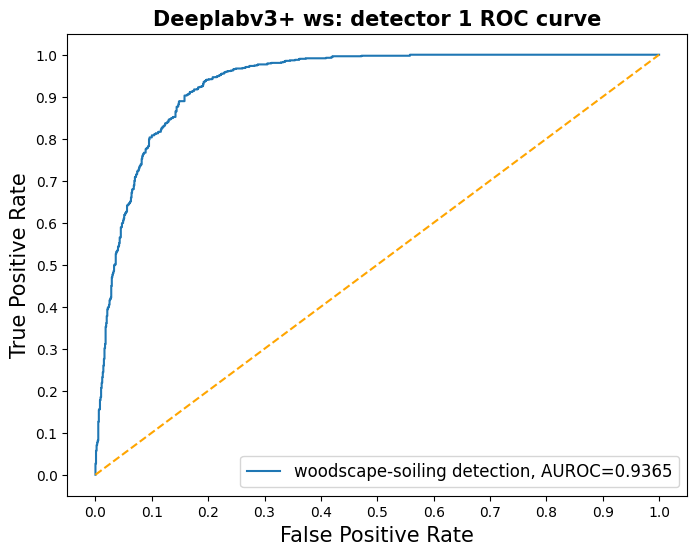

In [60]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_1_results_test_ds_3,
                      "woodscape-soiling detection",
                      "Deeplabv3+ ws: detector 1 ROC curve")

## Train Dataset 2: ws-normal-valid & cs-normal-valid

Train dataset set with sample imbalance:

- __InD/Normal__: ws-normal-valid (1482 samples)
- __OoD/Anomaly__: cs-normal-valid (500 samples)

In [63]:
(h_train_ws_normal_valid_cs_normal_valid,
 labels_h_train_ws_normal_valid_cs_normal_valid,
 h_test_ws_normal_test_cs_normal_test,
 labels_h_test_ws_normal_test_cs_normal_test, _) = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                          ws_dlv3p_h_z_cs_483640_valid_samples_np,  # reference for training set
                                                                          ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                          ws_dlv3p_h_z_cs_483640_test_samples_np)

Train Dataset Samples shape:  (1982, 16)
Train Dataset Labels shape:  (1982,)
Test Dataset Samples shape:  (2348, 16)
Test Dataset Labels shape:  (2348,)


### Test Dataset 1: ws-normal-test & cs-normal-test

In [64]:
ic(h_test_ws_normal_test_cs_normal_test.shape);
ic(labels_h_test_ws_normal_test_cs_normal_test.shape);

ic| h_test_ws_normal_test_cs_normal_test.shape: (2348, 16)
ic| labels_h_test_ws_normal_test_cs_normal_test.shape: (2348,)


### Test Dataset 2: ws-normal-test & ws-anomal-test

In [65]:
_, _, h_test_ws_normal_test_ws_anomal_test, labels_h_test_ws_normal_test_ws_anomal_test, _ = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_cs_483640_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                                                                    ws_dlv3p_h_z_ws_anomal_test_samples_np)

Train Dataset Samples shape:  (1982, 16)
Train Dataset Labels shape:  (1982,)
Test Dataset Samples shape:  (1646, 16)
Test Dataset Labels shape:  (1646,)


### Test Datset 3: ws-normal-test & ws-soiling-test

In [66]:
_, _, h_test_ws_normal_test_ws_soil_test, labels_h_test_ws_normal_test_ws_soil_test, _ = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                                                                ws_dlv3p_h_z_cs_483640_valid_samples_np,  # reference for training set
                                                                                                                ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                                                                ws_dlv3p_h_z_ws_soil_483640_test_samples_np)

Train Dataset Samples shape:  (1982, 16)
Train Dataset Labels shape:  (1982,)
Test Dataset Samples shape:  (1823, 16)
Test Dataset Labels shape:  (1823,)


## Train Model Dataset 2: ws-normal-valid & cs-normal-valid

In [67]:
dlv3p_ws_h_z_odd_detector_2 = KDEClassifier(bandwidth=0.8)
dlv3p_ws_h_z_odd_detector_2.fit(h_train_ws_normal_valid_cs_normal_valid, labels_h_train_ws_normal_valid_cs_normal_valid)

KDEClassifier(bandwidth=0.8)

## Results Test Dataset 1

In [74]:
dlv3p_ws_h_z_odd_detector_2_results_test_ds_1 = get_ood_detector_results("dlv3p-ws detector 2: test ds 1",
                                                                         dlv3p_ws_h_z_odd_detector_2,
                                                                         h_test_ws_normal_test_cs_normal_test,
                                                                         labels_h_test_ws_normal_test_cs_normal_test)

dlv3p_ws_h_z_odd_detector_2_results_test_ds_1
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_1['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_1['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_1['f1'][0].item()))

dlv3p-ws detector 2: test ds 1
AUROC: 1.0000
FPR95: 0.0000
F1: 0.9994


dlv3p-ws detector 2: test ds 1


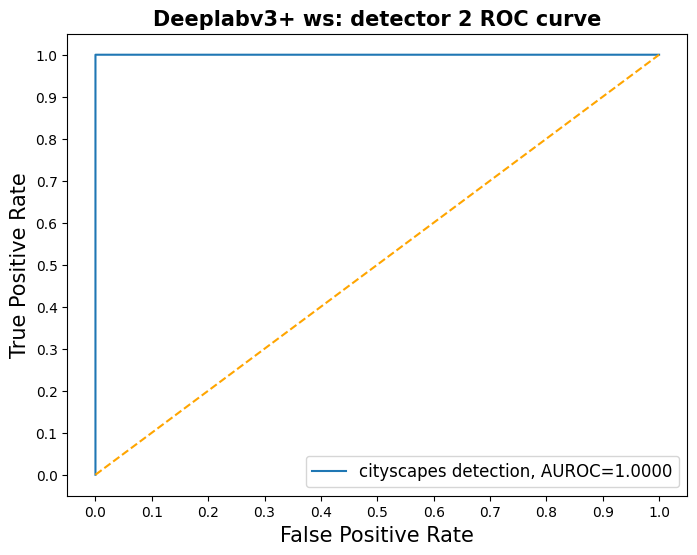

In [75]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_2_results_test_ds_1,
                      "cityscapes detection",
                      "Deeplabv3+ ws: detector 2 ROC curve")

## Results Test Dataset 2

In [76]:
dlv3p_ws_h_z_odd_detector_2_results_test_ds_2 = get_ood_detector_results("dlv3p-ws detector 2: test ds 2",
                                                                         dlv3p_ws_h_z_odd_detector_2,
                                                                         h_test_ws_normal_test_ws_anomal_test,
                                                                         labels_h_test_ws_normal_test_ws_anomal_test)

dlv3p_ws_h_z_odd_detector_2_results_test_ds_2
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_2['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_2['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_2['f1'][0].item()))

dlv3p-ws detector 2: test ds 2
AUROC: 0.9356
FPR95: 0.2321
F1: 0.7620


dlv3p-ws detector 2: test ds 2


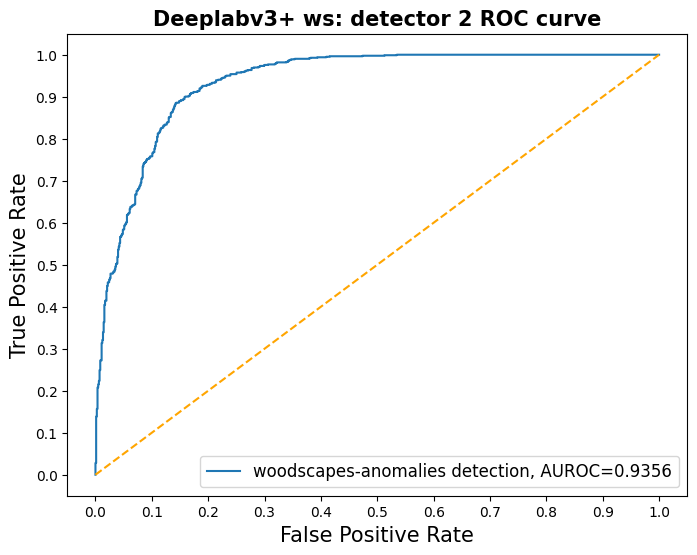

In [77]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_2_results_test_ds_2,
                      "woodscapes-anomalies detection",
                      "Deeplabv3+ ws: detector 2 ROC curve")

## Results Test Dataset 3

In [78]:
dlv3p_ws_h_z_odd_detector_2_results_test_ds_3 = get_ood_detector_results("dlv3p-ws detector 2: test ds 3",
                                                                         dlv3p_ws_h_z_odd_detector_2,
                                                                         h_test_ws_normal_test_ws_soil_test,
                                                                         labels_h_test_ws_normal_test_ws_soil_test)

dlv3p_ws_h_z_odd_detector_2_results_test_ds_3
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_3['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_3['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_2_results_test_ds_3['f1'][0].item()))

dlv3p-ws detector 2: test ds 3
AUROC: 0.9821
FPR95: 0.0910
F1: 0.7827


dlv3p-ws detector 2: test ds 3


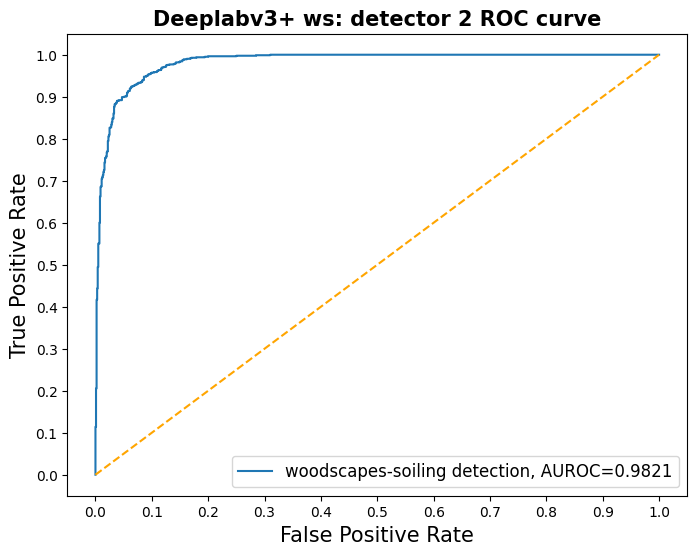

In [79]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_2_results_test_ds_3,
                      "woodscapes-soiling detection",
                      "Deeplabv3+ ws: detector 2 ROC curve")

## Train Dataset 3: ws-normal-valid vs ws-soling-valid

Train dataset set with sample imbalance:

- __InD/Normal__: ws-normal-valid (1482 samples)
- __OoD/Anomaly__: ws-soiling-valid (800 samples)

In [82]:
(h_train_ws_normal_valid_ws_soil_valid,
 labels_h_train_ws_normal_valid_ws_soil_valid,
 h_test_ws_normal_test_ws_soil_test,
 labels_h_test_ws_normal_test_ws_soil_test, _) = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                          ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,  # reference for training set
                                                                          ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                          ws_dlv3p_h_z_ws_soil_483640_test_samples_np)

Train Dataset Samples shape:  (2282, 16)
Train Dataset Labels shape:  (2282,)
Test Dataset Samples shape:  (1823, 16)
Test Dataset Labels shape:  (1823,)


### Test Dataset 1: ws-normal-test & ws-soiling-test

In [83]:
ic(h_test_ws_normal_test_ws_soil_test.shape);
ic(labels_h_test_ws_normal_test_ws_soil_test.shape);

ic| h_test_ws_normal_test_ws_soil_test.shape: (1823, 16)
ic| labels_h_test_ws_normal_test_ws_soil_test.shape: (1823,)


### Test Dataset 2: ws-normal-test & ws-anomal-test

In [84]:
_, _, h_test_ws_normal_test_ws_anomal_test, labels_h_test_ws_normal_test_ws_anomal_test, _ = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                                                                    ws_dlv3p_h_z_ws_anomal_test_samples_np)

Train Dataset Samples shape:  (2282, 16)
Train Dataset Labels shape:  (2282,)
Test Dataset Samples shape:  (1646, 16)
Test Dataset Labels shape:  (1646,)


### Test Dataset 3: ws-normal-test & cs-normal-test

In [85]:
_, _, h_test_ws_normal_test_cs_normal_test, labels_h_test_ws_normal_test_cs_normal_test, _ = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_normal_test_samples_np,
                                                                                                                    ws_dlv3p_h_z_cs_483640_test_samples_np)

Train Dataset Samples shape:  (2282, 16)
Train Dataset Labels shape:  (2282,)
Test Dataset Samples shape:  (2348, 16)
Test Dataset Labels shape:  (2348,)


## Train Model Dataset 3: ws-normal-valid & ws-soiling-valid

In [86]:
dlv3p_ws_h_z_odd_detector_3 = KDEClassifier(bandwidth=0.8)
dlv3p_ws_h_z_odd_detector_3.fit(h_train_ws_normal_valid_ws_soil_valid, labels_h_train_ws_normal_valid_ws_soil_valid)

KDEClassifier(bandwidth=0.8)

## Results Test Dataset 1

In [87]:
dlv3p_ws_h_z_odd_detector_3_results_test_ds_1 = get_ood_detector_results("dlv3p-ws detector 3: test ds 1",
                                                                         dlv3p_ws_h_z_odd_detector_3,
                                                                         h_test_ws_normal_test_ws_soil_test,
                                                                         labels_h_test_ws_normal_test_ws_soil_test)

dlv3p_ws_h_z_odd_detector_3_results_test_ds_1
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_1['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_1['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_1['f1'][0].item()))

dlv3p-ws detector 3: test ds 1
AUROC: 0.9998
FPR95: 0.0010
F1: 0.9886


dlv3p-ws detector 3: test ds 1


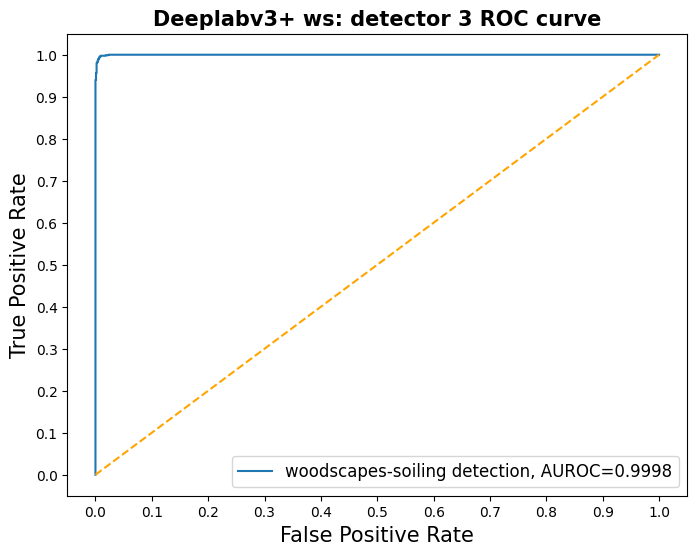

In [88]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_3_results_test_ds_1,
                      "woodscapes-soiling detection",
                      "Deeplabv3+ ws: detector 3 ROC curve")

## Results Test Dataset 2

In [89]:
dlv3p_ws_h_z_odd_detector_3_results_test_ds_2 = get_ood_detector_results("dlv3p-ws detector 3: test ds 2",
                                                                         dlv3p_ws_h_z_odd_detector_3,
                                                                         h_test_ws_normal_test_ws_anomal_test,
                                                                         labels_h_test_ws_normal_test_ws_anomal_test)

dlv3p_ws_h_z_odd_detector_3_results_test_ds_2
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_2['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_2['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_2['f1'][0].item()))

dlv3p-ws detector 3: test ds 2
AUROC: 0.8968
FPR95: 0.3208
F1: 0.7682


dlv3p-ws detector 3: test ds 2


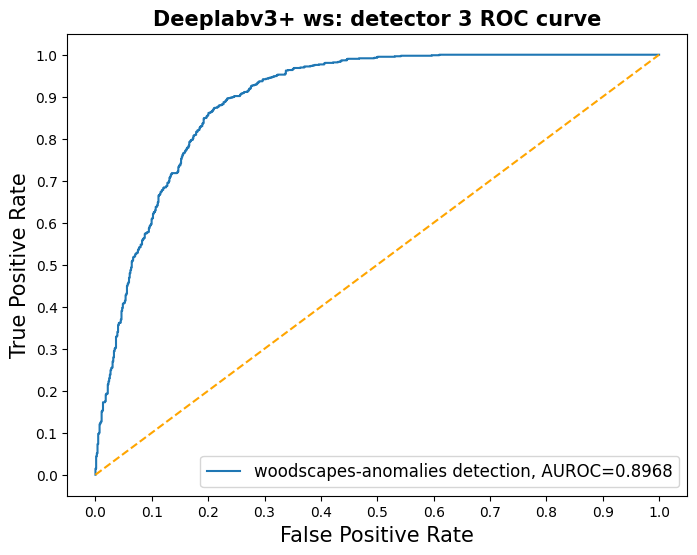

In [90]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_3_results_test_ds_2,
                      "woodscapes-anomalies detection",
                      "Deeplabv3+ ws: detector 3 ROC curve")

## Results Test Dataset 3

In [95]:
dlv3p_ws_h_z_odd_detector_3_results_test_ds_3 = get_ood_detector_results("dlv3p-ws detector 3: test ds 3",
                                                                         dlv3p_ws_h_z_odd_detector_3,
                                                                         h_test_ws_normal_test_cs_normal_test,
                                                                         labels_h_test_ws_normal_test_cs_normal_test)

dlv3p_ws_h_z_odd_detector_3_results_test_ds_3
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_3['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_3['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_3_results_test_ds_3['f1'][0].item()))

dlv3p-ws detector 3: test ds 3
AUROC: 0.9686
FPR95: 0.0603
F1: 0.8843


dlv3p-ws detect. 3: ws-normal vs cs-normal


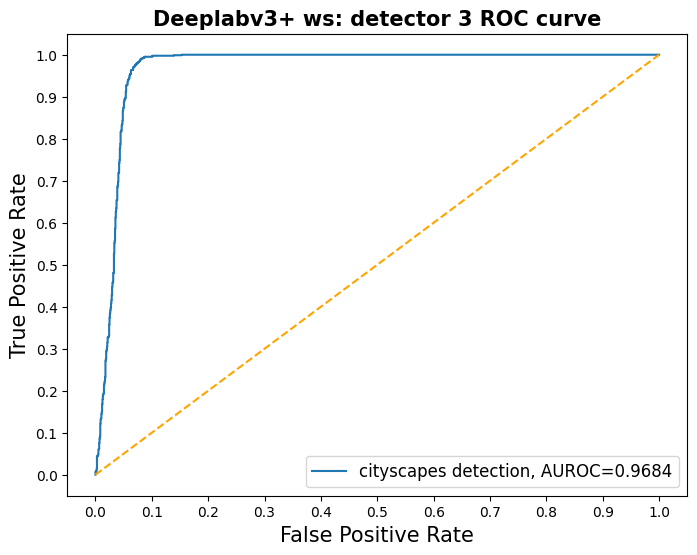

In [70]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_3_results_test_ds_3,
                      "cityscapes detection",
                      "Deeplabv3+ ws: detector 3 ROC curve")

## Train Dataset 4: ws-normal-test vs ws-soling-valid

Train dataset set with sample imbalance:

- __InD/Normal__: ws-normal-test (823 samples)
- __OoD/Anomaly__: ws-soiling-valid (800 samples)

In [98]:
(h_train_ws_normal_test_ws_soil_valid,
 labels_h_train_ws_normal_test_ws_soil_valid,
 h_test_ws_normal_valid_ws_soil_test,
 labels_h_test_ws_normal_valid_ws_soil_test, _) = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_test_samples_np,  # reference for training set
                                                                         ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,  # reference for training set
                                                                         ws_dlv3p_h_z_ws_normal_valid_samples_np,
                                                                         ws_dlv3p_h_z_ws_soil_483640_test_samples_np)

Train Dataset Samples shape:  (1623, 16)
Train Dataset Labels shape:  (1623,)
Test Dataset Samples shape:  (2482, 16)
Test Dataset Labels shape:  (2482,)


### Test Dataset 1: ws-normal-test & ws-soiling-test

In [99]:
ic(h_test_ws_normal_valid_ws_soil_test.shape);
ic(labels_h_test_ws_normal_valid_ws_soil_test.shape);

ic| h_test_ws_normal_valid_ws_soil_test.shape: (2482, 16)
ic| labels_h_test_ws_normal_valid_ws_soil_test.shape: (2482,)


### Test Dataset 2: ws-normal-valid & ws-anomal-test

In [107]:
_, _, h_test_ws_normal_valid_ws_anomal_test, labels_h_test_ws_normal_valid_ws_anomal_test, _ = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_test_samples_np,  # reference for training set
                                                                                                                      ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,  # reference for training set
                                                                                                                      ws_dlv3p_h_z_ws_normal_valid_samples_np,
                                                                                                                      ws_dlv3p_h_z_ws_anomal_test_samples_np)

Train Dataset Samples shape:  (1623, 16)
Train Dataset Labels shape:  (1623,)
Test Dataset Samples shape:  (2305, 16)
Test Dataset Labels shape:  (2305,)


### Test Dataset 3: ws-normal-valid & cs-normal-test

In [101]:
_, _, h_test_ws_normal_test_cs_normal_test, labels_h_test_ws_normal_test_cs_normal_test, _ = build_ood_detection_ds(ws_dlv3p_h_z_ws_normal_test_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_soil_483640_valid_samples_np,  # reference for training set
                                                                                                                    ws_dlv3p_h_z_ws_normal_valid_samples_np,
                                                                                                                    ws_dlv3p_h_z_cs_483640_test_samples_np)

Train Dataset Samples shape:  (1623, 16)
Train Dataset Labels shape:  (1623,)
Test Dataset Samples shape:  (3007, 16)
Test Dataset Labels shape:  (3007,)


## Train Model Dataset 4: ws-normal-test & ws-soiling-valid

In [102]:
dlv3p_ws_h_z_odd_detector_4 = KDEClassifier(bandwidth=0.8)
dlv3p_ws_h_z_odd_detector_4.fit(h_train_ws_normal_test_ws_soil_valid, labels_h_train_ws_normal_test_ws_soil_valid)

KDEClassifier(bandwidth=0.8)

## Results Test Dataset 1

In [104]:
dlv3p_ws_h_z_odd_detector_4_results_test_ds_1 = get_ood_detector_results("dlv3p-ws detector 4: test ds 1",
                                                                         dlv3p_ws_h_z_odd_detector_4,
                                                                         h_test_ws_normal_valid_ws_soil_test,
                                                                         labels_h_test_ws_normal_valid_ws_soil_test)

dlv3p_ws_h_z_odd_detector_4_results_test_ds_1
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_1['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_1['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_1['f1'][0].item()))

dlv3p-ws detector 4: test ds 1
AUROC: 0.9994
FPR95: 0.0030
F1: 0.9929


dlv3p-ws detector 4: test ds 1


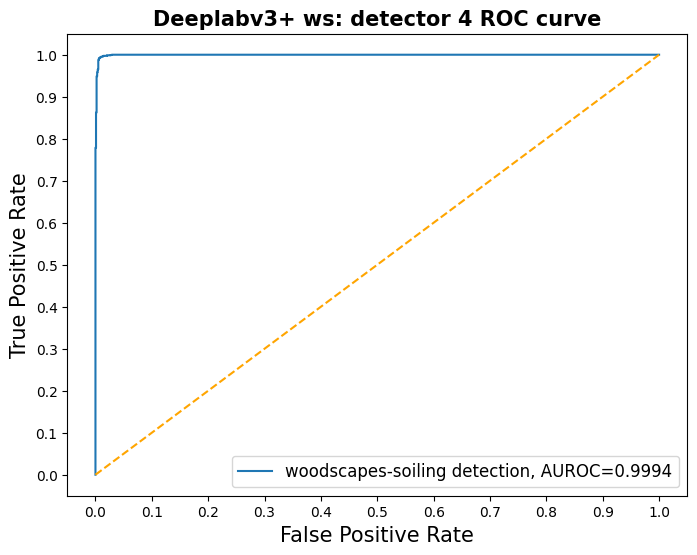

In [109]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_4_results_test_ds_1,
                      "woodscapes-soiling detection",
                      "Deeplabv3+ ws: detector 4 ROC curve")

## Results Test Dataset 2

In [108]:
dlv3p_ws_h_z_odd_detector_4_results_test_ds_2 = get_ood_detector_results("dlv3p-ws detector 4: test ds 2",
                                                                         dlv3p_ws_h_z_odd_detector_4,
                                                                         h_test_ws_normal_valid_ws_anomal_test,
                                                                         labels_h_test_ws_normal_valid_ws_anomal_test)

dlv3p_ws_h_z_odd_detector_4_results_test_ds_2
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_2['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_2['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_2['f1'][0].item()))

dlv3p-ws detector 4: test ds 2
AUROC: 0.9007
FPR95: 0.3354
F1: 0.8646


dlv3p-ws detector 4: test ds 2


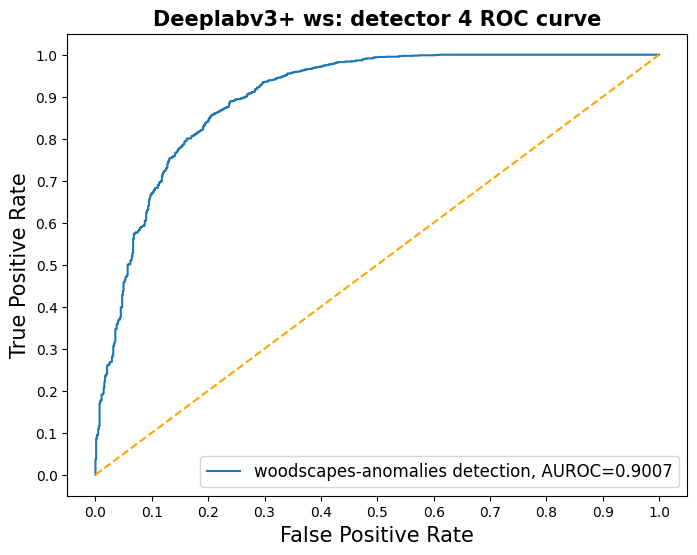

In [110]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_4_results_test_ds_2,
                      "woodscapes-anomalies detection",
                      "Deeplabv3+ ws: detector 4 ROC curve")

## Results Test Dataset 3

In [111]:
dlv3p_ws_h_z_odd_detector_4_results_test_ds_3 = get_ood_detector_results("dlv3p-ws detector 4: test ds 3",
                                                                         dlv3p_ws_h_z_odd_detector_4,
                                                                         h_test_ws_normal_test_cs_normal_test,
                                                                         labels_h_test_ws_normal_test_cs_normal_test)

dlv3p_ws_h_z_odd_detector_4_results_test_ds_3
print("AUROC: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_3['auc'][0].item()))
print("FPR95: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_3['fpr@95'][0].item()))
print("F1: {:0.4f}".format(dlv3p_ws_h_z_odd_detector_4_results_test_ds_3['f1'][0].item()))

dlv3p-ws detector 4: test ds 3
AUROC: 0.9987
FPR95: 0.0039
F1: 0.9756


dlv3p-ws detector 4: test ds 3


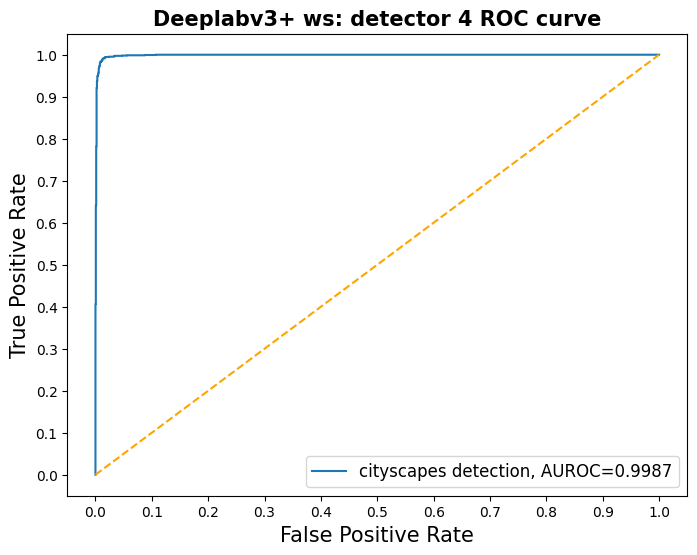

In [112]:
plot_roc_ood_detector(dlv3p_ws_h_z_odd_detector_4_results_test_ds_3,
                      "cityscapes detection",
                      "Deeplabv3+ ws: detector 4 ROC curve")